In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.linalg as la
import scipy.integrate as integrate
import kwant
from scipy.linalg import ishermitian

This code attempts to replicate the results of PhysRevB.107.094310 (Olin and Lee), and then extend on their idea by applying the incommensurate limit.


This block sets up the initial hamiltonian for a finite chain. 

In [4]:
sigmax = np.matrix([[0., 1.],[1., 0.]])
sigmay = np.matrix([[0., -1j*1.],[1j*1., 0.]])
sigmaz = np.matrix([[1., 0.],[0., -1.]])

U1 = lambda u, w1, w2, a, t: u*(1 + 2*np.cos(w1*t) + 2*a*np.cos(w2*t))
U2 = lambda u, w1, w2, a, t: u*(1 - 2*np.cos(w1*t) - 2*a*np.cos(w2*t))
Va = lambda v, w1, w2, a, theta, t: v*(np.cos(w1*t + theta) + a*np.cos(w2*t + theta))
Vb = lambda v, w1, w2, a, theta, t: v*(np.cos(w1*t - theta) + a*np.cos(w2*t - theta))

def twodriveSSH_ham(u, v, w1, w2, theta, alpha, t, L):
    u1 = U1(u, w1, w2, alpha, t)
    u2 = U2(u, w1, w2, alpha, t)
    va = Va(v, w1, w2, alpha, theta, t)
    vb = Vb(v, w1, w2, alpha, theta, t)
    
    lat = kwant.lattice.chain()
    sys = kwant.Builder()
    A = lambda i: lat(2 * i)
    B = lambda i: lat(2 * i + 1)
    
    for i in range(L):  #onsite
        sys[A(i)] = 0.0
        sys[B(i)] = 0.0
    
    for i in range(L):  # Intracell A to B
        sys[A(i), B(i)] = u1 
    
    for i in range(L - 1):  
        sys[A(i), B(i + 1)] = u2  # Intercell Ai to Bi
        sys[A(i), A(i + 1)] = va  # Intercell Ai to Ai+1 
        sys[B(i), B(i + 1)] = vb  # Intercell Bi to Bi+1  
    f_sys = sys.finalized()
    ham = f_sys.hamiltonian_submatrix(sparse=False)
    return ham

We need to calculate the Flouqet hamiltonian for m floquet modes which will give us 2mn x 2mn Floquet hamiltonian for n unit cells. 

In [5]:
def twodriveSSH_nm_ham(n, m, u, v, w1, w2, w, theta, alpha, L):
    t = 2*np.pi/w
    lat = kwant.lattice.chain(norbs=1)
    sys = kwant.Builder()
    A = lambda i: lat(2 * i)
    B = lambda i: lat(2 * i + 1)
    
    for i in range(L):  #onsite
        sys[A(i)] = 0.0
        sys[B(i)] = 0.0

    u1 = (1/t)*(integrate.quad(lambda t: np.real(( U1(u, w1, w2, alpha, t) )*np.exp(1j*(m-n)*w*t)), 0, 2*np.pi/w)[0] + 1j*integrate.quad(lambda t: np.imag(( U1(u, w1, w2, alpha, t) )*np.exp(1j*(m-n)*w*t)), 0, 2*np.pi/w)[0])
    for i in range(L):  # Intracell A to B
        sys[A(i), B(i)] = u1

    u2 = (1/t)*(integrate.quad(lambda t: np.real(( U2(u, w1, w2, alpha, t) )*np.exp(1j*(m-n)*w*t)), 0, 2*np.pi/w)[0] + 1j*integrate.quad(lambda t: np.imag(( U2(u, w1, w2, alpha, t) )*np.exp(1j*(m-n)*w*t)), 0, 2*np.pi/w)[0])
    va = (1/t)*(integrate.quad(lambda t: np.real(( Va(v, w1, w2, alpha, theta, t) )*np.exp(1j*(m-n)*w*t)), 0, 2*np.pi/w)[0] + 1j*integrate.quad(lambda t: np.imag( Va(v, w1, w2, alpha, theta, t)*np.exp(1j*(m-n)*w*t)), 0, 2*np.pi/w)[0])
    vb = (1/t)*(integrate.quad(lambda t: np.real(( Va(v, w1, w2, alpha, theta, t) )*np.exp(1j*(m-n)*w*t)), 0, 2*np.pi/w)[0] + 1j*integrate.quad(lambda t: np.imag( Va(v, w1, w2, alpha, theta, t)*np.exp(1j*(m-n)*w*t)), 0, 2*np.pi/w)[0])
    for i in range(L - 1):  
        sys[A(i), B(i + 1)] = u2  # Intercell Ai to Bi
        sys[A(i), A(i + 1)] = va  # Intercell Ai to Ai+1 
        sys[B(i), B(i + 1)] = vb  # Intercell Bi to Bi+1  
    f_sys = sys.finalized()
    ham = f_sys.hamiltonian_submatrix(sparse=False)
    return ham
    

def Hf(lat, u, v, w1, w2, w, theta, alpha, L):
    blocks = []
    for i in range(1, lat+1):
        row = []
        for j in range(1, lat+1):
            matij = twodriveSSH_nm_ham(i, j, u, v, w1, w2, w, theta, alpha, L)
            if (i==j):
                matij = matij - i*w*np.eye(2*L,dtype=complex)
            row.append(matij)
        blocks.append(row)
    m = np.block(blocks)
    # for i in range(m.shape[0]):
    #     m[i,i] = m[i,i] - i*W
    return m

In [6]:
p = 1
q = 2
w2 = 1
w1 = (p/q)*w2
w = w2/q
alpha = 1
u = 1.2
v = 1
theta = 1
L = 20

ham = Hf(3, u, v, w1, w2, w, theta, alpha, L)

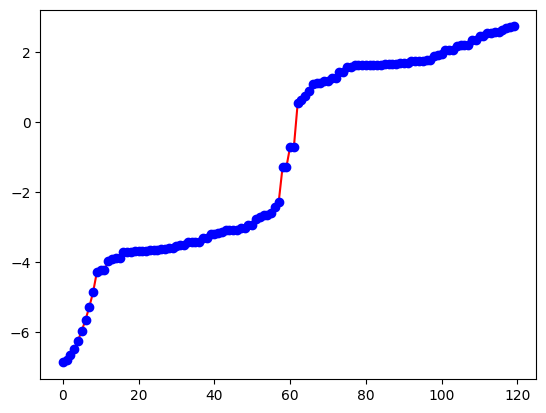

In [7]:
eigs = np.sort(la.eigvals(ham))
plt.plot(np.real(eigs), 'r-')
plt.plot(np.real(eigs), 'bo')
plt.show()

In [8]:
def calculate_bott(H, Lx, Ly, ndof=2):
    L = Lx * Ly
    dim = ndof * L

    # --- Site coordinates (1D arrays) ---
    cell_x = np.zeros(dim, dtype=int)
    cell_y = np.zeros(dim, dtype=int)

    for x in range(Lx):
        for y in range(Ly):
            i = x * Ly + y
            for sub in range(ndof):
                idx = ndof * i + sub
                cell_x[idx] = x
                cell_y[idx] = y

    # --- Diagonalize Hamiltonian ---
    evals, evecs = la.eigh(H)

    # --- Projector onto occupied states ---
    occupied = evals < 0
    P = evecs[:, occupied] @ evecs[:, occupied].conj().T

    # --- Unitary position operators ---
    theta = (2.0 * np.pi / Lx) * cell_x
    phi_b = (2.0 * np.pi / Ly) * cell_y
    Ux = np.diag(np.exp(1j * theta))
    Uy = np.diag(np.exp(1j * phi_b))

    # --- Projected unitaries ---
    U = P @ Ux @ P
    V = P @ Uy @ P

    # --- Bott Operator ---
    W = V @ U @ V.conj().T @ U.conj().T

    # --- Bott index ---
    eigvals_W = la.eigvals(W)
    trace_log = np.sum(np.log(eigvals_W[np.abs(eigvals_W) > 1e-12]))
    bott_index = np.imag(trace_log) / (2 * np.pi)

    return bott_index

In [9]:
calculate_bott(ham, 20, 3)

-1.0000000000000784

In [10]:
p = 1
q = 2
w2 = 0.1
w1 = (p/q)*w2
w = w2/q
alpha = 0.5
u = 1
v = 1.5
theta = 0
L = 20
modes = 3
bi_a = [calculate_bott(Hf(modes, u, v, w1, w2, w, theta, i, L), L, modes) for i in np.arange(0,4,0.1)]
# bi_th = [calculate_bott(Hf(modes, u, v, w1, w2, w, i, 1, L), L, modes) for i in np.arange(-1,1,0.1)]

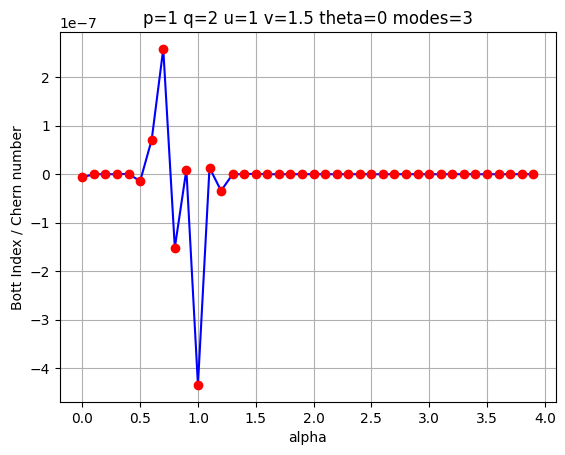

In [11]:
plt.plot(np.arange(0,4,0.1),bi_a, 'b-')
plt.plot(np.arange(0,4,0.1),bi_a, 'ro')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('Bott Index / Chern number')
plt.title('p='+str(p)+' q='+str(q)+' u='+str(u)+' v='+str(v)+' theta='+str(theta)+' modes='+str(modes))
plt.show()